## This is a tutorial on how to use pretrained model and adapt it in different classification task

### Let's first load our model and freeze all the layers except the top four - which we will be traning

In [1]:
from keras.applications import MobileNet

# MobileNet was designed to work on images with size 224x224 
img_width, img_height = 224,224

# images are in RGB format so let's define it
num_of_channels = 3

# Reload the MobileNet without the top FC layers
MobileNet = MobileNet(weights = 'imagenet', 
                      include_top = False,
                      input_shape = (img_width, img_height, num_of_channels))


Using TensorFlow backend.


#### Now let's freeze the last four layers, layers are set as trainable by default

In [2]:
for layer in MobileNet.layers:
    layer.trainable = False

# let's print our layers
for i, layer in enumerate(MobileNet.layers):
    
    print(f'{i} {layer.__class__.__name__} {layer.trainable}')


0 InputLayer False
1 ZeroPadding2D False
2 Conv2D False
3 BatchNormalization False
4 ReLU False
5 DepthwiseConv2D False
6 BatchNormalization False
7 ReLU False
8 Conv2D False
9 BatchNormalization False
10 ReLU False
11 ZeroPadding2D False
12 DepthwiseConv2D False
13 BatchNormalization False
14 ReLU False
15 Conv2D False
16 BatchNormalization False
17 ReLU False
18 DepthwiseConv2D False
19 BatchNormalization False
20 ReLU False
21 Conv2D False
22 BatchNormalization False
23 ReLU False
24 ZeroPadding2D False
25 DepthwiseConv2D False
26 BatchNormalization False
27 ReLU False
28 Conv2D False
29 BatchNormalization False
30 ReLU False
31 DepthwiseConv2D False
32 BatchNormalization False
33 ReLU False
34 Conv2D False
35 BatchNormalization False
36 ReLU False
37 ZeroPadding2D False
38 DepthwiseConv2D False
39 BatchNormalization False
40 ReLU False
41 Conv2D False
42 BatchNormalization False
43 ReLU False
44 DepthwiseConv2D False
45 BatchNormalization False
46 ReLU False
47 Conv2D False
48 Batc

In [3]:
print(MobileNet.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

#### We now make a function that will return  the fully connected layers of the MobileNet

In [4]:
def add_top_layers(bottom_model, num_of_classes):
    
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dense(512, activation='relu')(top_model)
    top_model = Dense(num_of_classes, activation='softmax')(top_model)
    
    return top_model
    

#### Now let's add a fully connected layers to our model

In [5]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Activation, Flatten, \
                            GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, BatchNormalization
    

In [6]:
num_of_classes = 10

fc_head = add_top_layers(MobileNet, num_of_classes)

model = Model(inputs = MobileNet.input, outputs = fc_head)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

In [7]:
from keras.preprocessing.image import ImageDataGenerator

train_data_dir = './monkey_breed/train'
validation_data_dir = './monkey_breed/validation'


In [8]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=45,
                                   width_shift_range=0.3,
                                   height_shift_range=0.3,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
batch_size = 32

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(img_width,img_height),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(validation_data_dir,
                                                              target_size=(img_width,img_height),
                                                              batch_size=batch_size,
                                                              class_mode='categorical')

Found 1097 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


#### Now let's define some callbacks and train our model

In [10]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import os

main_dir = os.getcwd()

checkpoint = ModelCheckpoint(os.path.join(main_dir,'mobile_net.h5'),
                             monitor='val_loss',
                             save_best_only=True,
                             verbose=1)

early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=0,
                           patience=3,
                           verbose=1,
                           restore_best_weights=True)


callbacks = [checkpoint, early_stop]

In [11]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr = 0.001),
              metrics= ['accuracy'])

nb_train_samples = 1097
nb_validation_samples = 272

epochs = 10

history = model.fit_generator(train_generator, steps_per_epoch=nb_train_samples//batch_size,  \
                              validation_steps=nb_validation_samples//batch_size, validation_data=validation_generator, \
                              epochs = epochs,
                              callbacks=callbacks)


Epoch 1/10
34/34 [==============================] - 47s 1s/step - loss: 3.1317 - acc: 0.2583 - val_loss: 1.2349 - val_acc: 0.6133

Epoch 00001: val_loss improved from inf to 1.23494, saving model to D:\Projects\Github Projects\Monkey Breed Classifier\mobile_net.h5
Epoch 2/10
34/34 [==============================] - 41s 1s/step - loss: 1.2020 - acc: 0.6198 - val_loss: 0.4673 - val_acc: 0.8292

Epoch 00002: val_loss improved from 1.23494 to 0.46725, saving model to D:\Projects\Github Projects\Monkey Breed Classifier\mobile_net.h5
Epoch 3/10
34/34 [==============================] - 44s 1s/step - loss: 0.7598 - acc: 0.7591 - val_loss: 0.2720 - val_acc: 0.9250

Epoch 00003: val_loss improved from 0.46725 to 0.27199, saving model to D:\Projects\Github Projects\Monkey Breed Classifier\mobile_net.h5
Epoch 4/10
34/34 [==============================] - 43s 1s/step - loss: 0.7032 - acc: 0.8097 - val_loss: 0.1576 - val_acc: 0.9375

Epoch 00004: val_loss improved from 0.27199 to 0.15756, saving mod

#### Let's now see some statistics and load our model

In [12]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


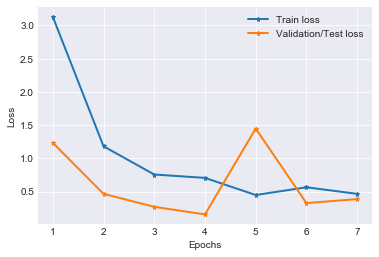

In [15]:
import matplotlib.pyplot as plt

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs_as_list = range(1, len(loss_values) +1)

plt.style.use('seaborn-darkgrid')

train_loss_line = plt.plot(epochs_as_list, loss_values, label = 'Train loss' )
test_loss_line = plt.plot(epochs_as_list, val_loss_values, label = 'Validation/Test loss' )

plt.setp(train_loss_line, linewidth = 2.0, marker ='*', markersize = 5.0)
plt.setp(test_loss_line, linewidth = 2.0, marker ='*', markersize = 5.0)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

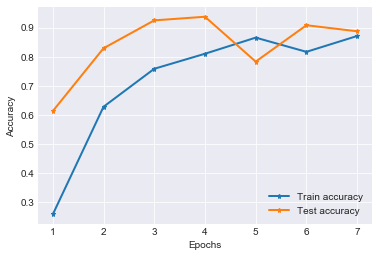

In [16]:
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

train_acc_line = plt.plot(epochs_as_list, acc_values, label='Train accuracy')
test_acc_line = plt.plot(epochs_as_list, val_acc_values, label='Test accuracy')

plt.setp(train_acc_line, linewidth = 2.0, marker = '*', markersize =5.0)
plt.setp(test_acc_line, linewidth=2.0, marker= '*', markersize = 5.0)


plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

#### Let's now load our model and see some classification results with our own eyes

In [28]:
from keras.models import load_model

classifier = load_model(os.path.join(main_dir,'mobile_net.h5'))

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random 

monkey_breeds_dict_n = {
    'n0':'mantled_howler',
    'n1':'patas_monkey',
    'n2':'bald_uakari',
    'n3':'japanese_macaque',
    'n4':'pygmy_marmoset',
    'n5':'white_headed_capuchin',
    'n6':'silvery_marmoset',
    'n7':'common_squirrel_monkey',
    'n8':'black_headed_night_monkey',
    'n9':'nilgiri_langur',
}

monkey_breeds_dict = {
    '[0]': 'mantled_howler',
    '[1]': 'patas_monkey',
    '[2]': 'bald_uakari',
    '[3]': 'japanese_macaque',
    '[4]': 'pygmy_marmoset',
    '[5]': 'white_headed_capuchin',
    '[6]': 'silvery_marmoset',
    '[7]': 'common_squirrel_monkey',
    '[8]': 'black_headed_night_monkey',
    '[9]': 'nilgiri_langur',
}


Class: mantled_howler
1/1 [==============================] - 0s 9ms/step
Class: mantled_howler
1/1 [==============================] - 0s 7ms/step
Class: patas_monkey
1/1 [==============================] - 0s 10ms/step
Class: black_headed_night_monkey
1/1 [==============================] - 0s 8ms/step
Class: black_headed_night_monkey
1/1 [==============================] - 0s 8ms/step
Class: bald_uakari
1/1 [==============================] - 0s 9ms/step
Class: black_headed_night_monkey
1/1 [==============================] - 0s 12ms/step
Class: black_headed_night_monkey
1/1 [==============================] - 0s 9ms/step
Class: patas_monkey
1/1 [==============================] - 0s 9ms/step
Class: nilgiri_langur
1/1 [==============================] - 0s 9ms/step
Class: nilgiri_langur
1/1 [==============================] - 0s 16ms/step
Class: common_squirrel_monkey
1/1 [==============================] - 0s 9ms/step
Class: black_headed_night_monkey
1/1 [==============================] - 0s 9

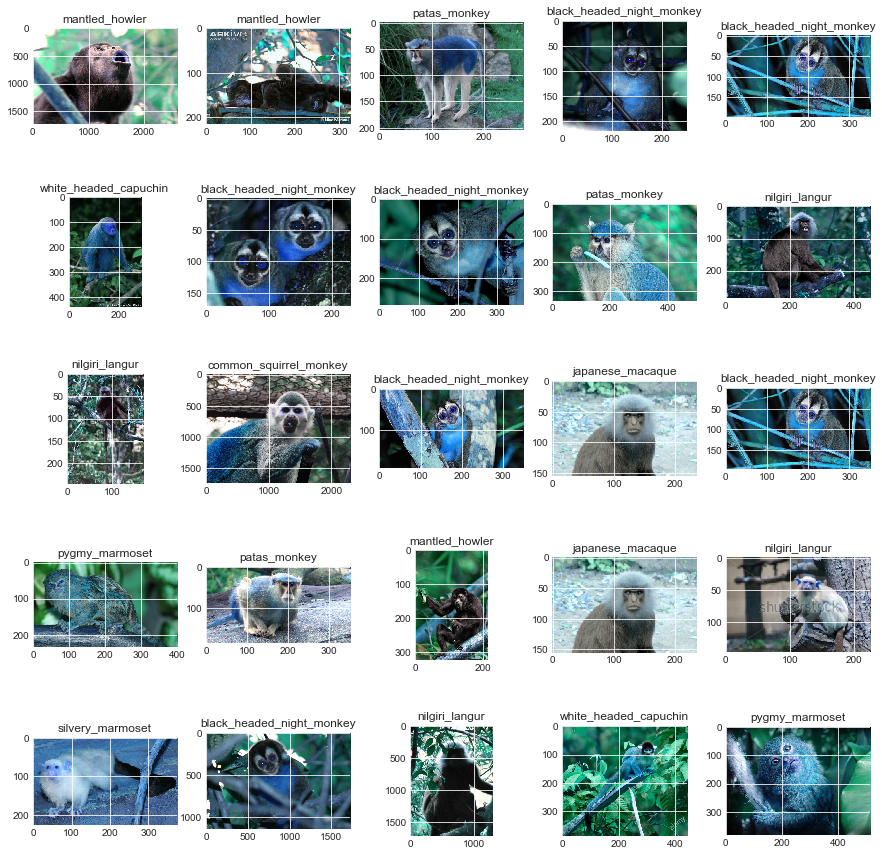

In [63]:
# let's read some validation images and display the results

def read_random_image(valid_path):
    
    folders = os.listdir(valid_path)
    random_dir = random.randint(0, len(folders)-1)
    #print(random_dir)
    path_class = folders[random_dir]
    #print(path_class)
    print(f'Class: {monkey_breeds_dict_n[str(path_class)]}')
    
    file_path = os.path.join(valid_path,path_class)
    #print(file_path)
    file_names = os.listdir(file_path)

    random_file_index = random.randint(0, len(file_names)-1)
    image_name = file_names[random_file_index]
    
    #print(os.path.join(file_path,image_name))
    return cv2.imread(os.path.join(file_path,image_name))


fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(15,15))
ax = ax.ravel()
for i in range(0, 25):
    
    original_image = read_random_image(validation_data_dir)
    input_image = original_image
    
    original_image = cv2.resize(original_image, None, fx=0.5, fy=0.5, interpolation = cv2.INTER_AREA)
    input_image = cv2.resize(input_image, (img_width,img_height), interpolation= cv2.INTER_AREA)
    
    input_image = input_image/255.
    input_image = input_image.reshape(1,img_width,img_height,num_of_channels)

    prediction = np.argmax(classifier.predict(input_image,1, verbose=1), axis =1)
    
    monkey_breed = monkey_breeds_dict[str(prediction)]
    
    ax[i].imshow(original_image)
    ax[i].set_title(monkey_breed)
    
plt.subplots_adjust(hspace=0.6)